In [1]:
import operator
from typing import Annotated, List, TypedDict, Union, Optional, Tuple, Literal
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
import functools

### Agents
from langchain.agents import AgentExecutor, create_openai_tools_agent, create_tool_calling_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain import hub
##

### Tools
from langchain_core.tools import tool
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool
# Utils
from pathlib import Path
###

from langgraph.constants import Send
from langgraph.graph import END, StateGraph, START, MessagesState
from langgraph.prebuilt import create_react_agent


USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
import os
from dotenv import load_dotenv
parent_dir = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
load_dotenv(os.path.join(parent_dir, '.env'))
os.environ["LANGCHAIN_TRACING_V2"] = "false"
load_dotenv() ## ensure that your .env file in the same directory as this notebook has the OpenAI API Key

True

In [3]:
# tool utils

WORKING_DIRECTORY = Path('./playground/multi_trace/dsph_fL1/')

# tavily_tool = TavilySearchResults(max_results=5) # TODO: get TavilyAPIKey
python_repl_tool = PythonREPLTool()

@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'\n{doc.page_content}\n'
            for doc in docs
        ]
    )

@tool # DEP:
def get_telemetry(queries: List[str]) -> str: 
    """Use Alessandro's API to request samples of traces and/or metrics (gauges or counters) from prometheus and jaeger.
    @TODO: refine type signature for input to be a tuple of counted calls
    @TODO: implement the actual functionality
    """
    pass


## -- File System Interaction Toolkit

# This will be run before the anomaly enumeration agents
# It makes it so they are more aware of the current state
# of the working directory.
def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except Exception:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are the files that exist in metrics filesystem DB:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }

@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])

tools = [python_repl_tool, read_document]

In [4]:
llm = ChatOpenAI(model="gpt-4o")
llm.bind_tools

In [5]:
executor_prompt = """You are an expert agent responsible for executing steps in a plan for anomaly detection in microservice applications. Your task is to carry out the current step and evaluate its outcome. 
{current_files}
"""
def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools, verbose=True)
    return executor
# Choose the LLM that will drive the agent
agent_executor = prelude | create_agent(llm, tools, executor_prompt)

In [6]:
class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [7]:

from langchain_core.prompts import ChatPromptTemplate


def create_objective(slo_violation: str) -> str: 
    return f"""
Objective: Detect anomalies in microservice application traces and metrics based on an SLO violation.

Context:
- You have access to a working directory containing:
  1. main_traces.csv: A summary of Jaeger traces for all calls in the workload, including headers for traceID, duration-ms, startTime, endTime, rpcErrors, operation, and services_involved.
  2. Individual trace tree JSON files, each named after its respective traceID.
- Anomalies may include errors, extreme bottlenecks, recursions, or other unusual patterns.
- The plan will be executed by an agent, not by you.

Specific SLO Violation: {slo_violation}

Required Output: Either a list of anomalous trace IDs with brief explanations of why they were flagged, or FALSE if no anomalies were found.

Additional Instructions:
- Do not execute any steps or perform any analysis yourself.
- Describe actions the execution agent should take at each step.
- Include steps for loading data, performing statistical analysis, identifying potential anomalies, and summarizing findings.
- Keep in mind that the executor agent will have access to the directory and appropriate files.
"""

# TODO: determine if the fused vs separated prompt are better
planner_prompt_text_expanded = """
You are an expert planner specializing in anomaly detection for microservice applications. Your task is to create a detailed step-by-step plan to investigate potential anomalies in telemetry data. This plan will be used by an execution agent, so you should not execute any steps yourself.

You will be planning based on the following scenario:

An SLO violation has occurred, and you have access to a working directory containing:

1. main_traces.csv: A summary of Jaeger traces for all calls in the workload, including headers for traceID, duration-ms, startTime, endTime, rpcErrors, operation, and services_involved.
2. Individual trace tree JSON files, each named after its respective traceID.

The objective is to analyze this data, identify any anomalies, and provide a summary of findings. Anomalies may include errors, extreme bottlenecks, recursions, or other unusual patterns.

Create a detailed plan to accomplish this task. Each step should be clear, concise, and contain all necessary information. The final step should describe how to present the results: either a list of anomalous trace IDs with a brief explanation of why they were flagged, or FALSE if no anomalies were found.

Your plan should include steps for:
- Loading and inspecting the data
- Analyzing trace durations, errors, and service interactions
- Identifying potential anomalies
- Investigating suspicious patterns in individual trace JSON files
- Compiling and summarizing findings

Remember, this is a planning task. Do not include steps for executing code or performing the analysis yourself. Instead, describe what actions the execution agent should take at each step.

Here's an example of how your plan might start:

1. Load the main_traces.csv file into a data analysis tool or framework.
2. Calculate basic statistics for the 'duration-ms' column (mean, median, standard deviation).
3. Identify traces with durations exceeding 2 standard deviations from the mean.
4. Create a list of all unique 'services_involved' and their frequency of occurrence.
5. Identify traces with 'rpcErrors' greater than zero.
6. For each potential anomaly identified in steps 3 and 5, locate the corresponding JSON file using the traceID.
7. ...

Continue the plan to cover all necessary steps for thorough anomaly detection and result reporting. The final step should describe how to present the findings.
"""

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps."""
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Plan)

In [8]:
class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Act)

In [9]:
async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": (task, agent_response["messages"][-1]),
        # "past_steps": (task, agent_response["messages"][-1].content),
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute) -> Literal["agent", "__end__"]:
    if "response" in state and state["response"]:
        return "__end__"
    else:
        return "agent"


In [10]:
workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

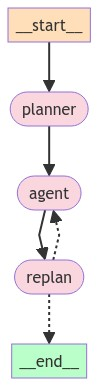

In [11]:

from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [12]:
config = {"recursion_limit": 50}
inputs = {"input": create_objective("We have observed an increase in service latency above 2 seconds for more than 20% of user requests, violating service level agreements.")}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['Load the main_traces.csv file into a DataFrame.', 'Filter the DataFrame to include only traces with duration-ms greater than 2000 milliseconds.', 'Calculate the percentage of traces that exceed the 2000 milliseconds threshold.', 'If the percentage of traces exceeding the threshold is less than or equal to 20%, return FALSE and stop further analysis.', 'For each trace that exceeds the 2000 milliseconds threshold, load the corresponding JSON trace tree file using the traceID.', 'Analyze each JSON trace tree file for anomalies such as rpcErrors, extreme bottlenecks, recursions, or other unusual patterns.', 'Compile a list of trace IDs that exhibit anomalies along with brief explanations for each anomaly.', 'Return the list of anomalous trace IDs with explanations.']}


> Entering new AgentExecutor chain...

Invoking: `read_document` with `{'file_name': 'f1/unknown_service:frontend_service_process.csv'}`


ec5866bd3cfa717a5f3dd31347fe6a89,5532.43,1721571409600370,172157141513280

Python REPL can execute arbitrary code. Use with caution.



Invoking: `Python_REPL` with `import pandas as pd
from io import StringIO

# CSV data
csv_data = '''traceID,duration-ms,start-time,end-time,rpcStatus,spanName,services


ec5866bd3cfa717a5f3dd31347fe6a89,5532.43,1721571409600370,1721571415132800,False,Nearby start,unknown_service:frontend_service_process;unknown_service:wlgen_proc;unknown_service:search_service_process

2b3bc1603f7a1f5f690e5151a7546cfb,5513.591,1721571413607947,1721571419121538,False,Nearby start,unknown_service:frontend_service_process;unknown_service:wlgen_proc;unknown_service:search_service_process

7c0a47e09a740513829e2d1d9c8785b4,5515.385,1721571410602370,1721571416117755,False,Nearby start,unknown_service:frontend_service_process;unknown_service:wlgen_proc;unknown_service:search_service_process

07ebbe0dab2565ca19e8195c9894073c,5514.105,1721571416612001,1721571422126106,False,Nearby start,unknown_service:frontend_service_process;unknown_service:wlgen_proc;unknown_service:search_service_process

a28592155f048496d4

AttributeError: 'tuple' object has no attribute 'content'